<a href="https://www.kaggle.com/code/adexdams/capstoneproj-google-adk?scriptVersionId=282447084" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📊 Daily Sales Report AI Agent System
### By: 🙍🏾‍♂️ Damola Adediran
---


#### Google Gemini & ADK Capstone Technologies:

##### 🤖 Multi-agent System, 📈 Data Pipeline Development, 🔧 Agent Tools & Agent as tools, 💾 Agent Memory (Context Engineering), 🔎 Agent Observability (Logging & Tracing agent sequence)

## Section 1: Project Summary
This project implementation includes the following:
- A data cleaning pipeline for an online sales dataset
- A daily-report generator (metrics, anomalies, trends)
- AI agents, agent tools, and orchestration workflow (daily_report_agent, summary_agent, followup_agent)
- Agent Observation and callbacks
- Agent Evaluation on ADK UI
- Local testing utilities and a Streamlit front-end prototype

Intended use: local development and testing before production deployment.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-sales-dataset/online_sales_dataset.csv


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GOOGLE_API_KEY")

In [3]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Setup and authentication complete.


### Configurations and Environments

* Environment check
* This cell verifies package versions and provides packages required for this to run.

In [4]:
# Import libraries for this notebook
import os
import re
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta, date
import decimal
import json
import asyncio
import logging
from typing import Any, Dict
from google.genai import types
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner, Runner
from google.adk.sessions import InMemorySessionService
from google.adk.memory import InMemoryMemoryService
from google.adk.tools import AgentTool, ToolContext, load_memory, preload_memory
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.agents.base_agent import BaseAgent
from google.adk.agents.callback_context import CallbackContext
from google.adk.models.llm_request import LlmRequest
from google.adk.plugins.base_plugin import BasePlugin
from google.adk.plugins.logging_plugin import (LoggingPlugin)

print("✅ ADK components imported successfully.")
print("✅ Libraries installed and the dataset has been loaded too.")

✅ ADK components imported successfully.
✅ Libraries installed and the dataset has been loaded too.


In [5]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

MODEL_NAME = "gemini-2.5-flash-lite"

# Set up Session Management
# InMemorySessionService stores conversations in RAM (temporary)
session_service = InMemorySessionService()

print("✅ Session state created.")

✅ Session state created.


In [6]:
# --------- Global Observation Plugin loaded -------

# Applies to all agent and model calls
class CountInvocationPlugin(BasePlugin):
    """A custom plugin that counts agent and tool invocations."""

    def __init__(self) -> None:
        """Initialize the plugin with counters."""
        super().__init__(name="count_invocation")
        self.agent_count: int = 0
        self.tool_count: int = 0
        self.llm_request_count: int = 0

    # Callback 1: Runs before an agent is called. You can add any custom logic here.
    async def before_agent_callback(
        self, *, agent: BaseAgent, callback_context: CallbackContext
    ) -> None:
        """Count agent runs."""
        self.agent_count += 1
        logging.info(f"[Plugin] Agent run count: {self.agent_count}")

    # Callback 2: Runs before a model is called. You can add any custom logic here.
    async def before_model_callback(
        self, *, callback_context: CallbackContext, llm_request: LlmRequest
    ) -> None:
        """Count LLM requests."""
        self.llm_request_count += 1
        logging.info(f"[Plugin] LLM request count: {self.llm_request_count}")

## Section 2: Data Loading & Exploration Process

#### The dataset was taken from Kaggle data store

The dataset comprises anonymized data on online sales transactions, capturing various aspects of product purchases, customer details, and order characteristics.

**Content of the dataset**

| Column Name        | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| InvoiceNo          | A unique identifier for each sales transaction (invoice).                   |
| StockCode          | The code representing the product stock-keeping unit (SKU).                 |
| Description        | A brief description of the product.                                         |
| Quantity           | The number of units of the product sold in the transaction.                 |
| InvoiceDate        | The date and time when the sale was recorded.                               |
| UnitPrice          | The price per unit of the product in the transaction currency.             |
| CustomerID         | A unique identifier for each customer.                                      |
| Country            | The customer's country.                                                     |
| Discount           | The discount applied to the transaction, if any.                            |
| PaymentMethod      | The method of payment used for the transaction (e.g. PayPal, Bank Transfer).|
| ShippingCost       | The cost of shipping for the transaction.                                   |
| Category           | The category to which the product belongs (e.g. Electronics, Apparel).      |
| SalesChannel       | The channel through which the sale was made (e.g. Online, In-store).        |
| ReturnStatus       | Indicates whether the item was returned or not.                             |
| ShipmentProvider   | The provider responsible for delivering the order (e.g. UPS, FedEx).        |
| WarehouseLocation  | The warehouse location from which the order was fulfilled.                  |
| OrderPriority      | The priority level of the order (e.g. High, Medium, Low).                   |

For more details: https://www.kaggle.com/datasets/yusufdelikkaya/online-sales-dataset

In [7]:
# Load dataset and inspect it

# -------- LOAD DATASETS --------
csv_path = "/kaggle/input/online-sales-dataset/online_sales_dataset.csv"
# ------------------------

#load for preview
df = pd.read_csv(csv_path)

In [8]:
#data inspection process - check the structure of the dataset
details = df.info()
details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49782 entries, 0 to 49781
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   InvoiceNo          49782 non-null  int64  
 1   StockCode          49782 non-null  object 
 2   Description        49782 non-null  object 
 3   Quantity           49782 non-null  int64  
 4   InvoiceDate        49782 non-null  object 
 5   UnitPrice          49782 non-null  float64
 6   CustomerID         44804 non-null  float64
 7   Country            49782 non-null  object 
 8   Discount           49782 non-null  float64
 9   PaymentMethod      49782 non-null  object 
 10  ShippingCost       47293 non-null  float64
 11  Category           49782 non-null  object 
 12  SalesChannel       49782 non-null  object 
 13  ReturnStatus       49782 non-null  object 
 14  ShipmentProvider   49782 non-null  object 
 15  WarehouseLocation  46297 non-null  object 
 16  OrderPriority      497

In [9]:
#data inspection process - check samples of the contents inside the dataset
preview = df.head()
preview

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority
0,221958,SKU_1964,White Mug,38,2020-01-01 00:00,1.71,37039.0,Australia,0.470000,Bank Transfer,10.79,Apparel,In-store,Not Returned,UPS,London,Medium
1,771155,SKU_1241,White Mug,18,2020-01-01 01:00,41.25,19144.0,Spain,0.190000,paypall,9.51,Electronics,Online,Not Returned,UPS,Rome,Medium
2,231932,SKU_1501,Headphones,49,2020-01-01 02:00,29.11,50472.0,Germany,0.350000,Bank Transfer,23.03,Electronics,Online,Returned,UPS,Berlin,High
3,465838,SKU_1760,Desk Lamp,14,2020-01-01 03:00,76.68,96586.0,Netherlands,0.140000,paypall,11.08,Accessories,Online,Not Returned,Royal Mail,Rome,Low
4,359178,SKU_1386,USB Cable,-30,2020-01-01 04:00,-68.11,NaN,United Kingdom,1.501433,Bank Transfer,NaN,Electronics,In-store,Not Returned,FedEx,NaN,Medium


In [10]:
#data inspection process - check for missing values
missing_values = df.isna().sum()
missing_values

InvoiceNo               0
StockCode               0
Description             0
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID           4978
Country                 0
Discount                0
PaymentMethod           0
ShippingCost         2489
Category                0
SalesChannel            0
ReturnStatus            0
ShipmentProvider        0
WarehouseLocation    3485
OrderPriority           0
dtype: int64

### Data Processing Pipeline

**Data cleaning: type normalization**
 - Convert InvoiceDate to datetime (coerce errors)
 - Ensure numeric columns (Quantity, UnitPrice, Discount, ShippingCost)
 - Provide a short printed summary of conversions and any missing values

**Data cleaning: fill categorical and standardize text**
 - Fill missing CustomerID, Category, SalesChannel, etc.
 - Strip strings and standardize casing if needed
 - Explain why these fills are acceptable (e.g., 'Unknown' placeholder)

**Data cleaning: normalize discount percentages and detect returns**
 - Convert 1-100 values to 0-1 where relevant
 - Create IsReturn flag from quantity and return text heuristics
 - Add comments explaining heuristics used

**Save cleaned DataFrame to a new variable**
 - For faster iteration you may want to save a cleaned copy: df.to_parquet(...) or to CSV
 - Note: make sure sanitized output does not store sensitive data

In [11]:
# --- 1. Helper Function ---

def fmt_money(x):
    """Formats a float to a currency string with commas and two decimals."""
    if isinstance(x, (float, int)) and not (np.isnan(x) or np.isinf(x)):
        return f"${x:,.2f}"
    return x

# --- 2. Data Preprocessing (Merged Load + Clean) ---

def preprocess_sales_data(csv_path: str) -> pd.DataFrame:
    """Load, clean, and compute necessary fields for the entire sales dataset."""
    df = pd.read_csv(csv_path, low_memory=False)

    # Type Conversion & Cleaning
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    for col in ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)

    # Fill missing categorical info
    cat_fill = {
        'CustomerID': 'Unknown', 'WarehouseLocation': 'Unknown', 'Description': '',
        'Category': 'Unknown', 'SalesChannel': 'Unknown', 'ReturnStatus': 'No Return'
    }
    for col, val in cat_fill.items():
        if col in df.columns:
            df[col] = df[col].fillna(val)

    # Normalize discounts (percentages to 0-1 range)
    if 'Discount' in df.columns:
        disc = df['Discount'].copy()
        mask_pct = (disc > 1) & (disc <= 100)
        disc.loc[mask_pct] = disc.loc[mask_pct] / 100.0
        df['Discount_norm'] = disc.clip(lower=0.0).fillna(0.0)
    else:
        df['Discount_norm'] = 0.0

    # Compute Net Revenue
    df['NetRevenue'] = df['Quantity'] * df['UnitPrice'] * (1.0 - df['Discount_norm'])

    # Date Normalization (Crucial for filtering efficiency)
    df['InvoiceDate_date'] = df['InvoiceDate'].dt.normalize()

    # Determine returns
    return_indicators = ['return', 'returned', 'refunded', 'rma']
    df['IsReturn'] = (
        (df['ReturnStatus'].astype(str).str.lower().fillna('').str.contains('|'.join(return_indicators))) |
        (df['Quantity'] < 0)
    )

    return df

print("✅ Preprocessor function loaded.")

✅ Preprocessor function loaded.


## Section 3: Report Generation Functions

**Build daily report**
 - Function: collects cleaned dataframe, requested date, looks back 28 days from there to understand trends and anomalies
 - Computes metrics: total_revenue, num_orders, aov, top_products, revenue_by_category, revenue_by_channel, top_countries, return_rate, anomalies, trend
 - Ensure outputs are JSON-safe: keys are strings, values are native Python types
 - Add a short doctest or example run to show the expected output shape

**Format helpers**
 - fmt_money(value) -> returns formatted string and numeric round for monetary metrics

In [12]:
# --- 3. Metric Calculation ---

def calculate_daily_metrics(df_all: pd.DataFrame, target_date_str: str, lookback_days_for_trend: int = 28) -> tuple[pd.DataFrame, dict]:
    """
    Calculates detailed daily sales metrics for the target date.
    Assumes df_all is already pre-processed and contains 'InvoiceDate_date' and 'NetRevenue'.
    """
    target_dt = pd.to_datetime(target_date_str).normalize()

    # 1. Subset for the exact date
    day_df = df_all[df_all['InvoiceDate_date'] == target_dt].copy().reset_index(drop=True)

    # Check for empty day
    if day_df.empty:
        empty_metrics = {
            'date': target_dt.strftime('%Y-%m-%d'), 'total_revenue': 0.0, 'num_orders': 0, 'top_products': {},
            'revenue_by_category': {}, 'revenue_by_channel': {}, 'top_countries': {}, 'anomalies_count': 0,
            'trend': {'prev_day_change_pct': None, 'week_change_pct': None}
        }
        return day_df, empty_metrics

    # 2. Basic Metrics
    total_revenue = day_df['NetRevenue'].sum()
    num_orders = day_df['InvoiceNo'].nunique()
    avg_order_value = (total_revenue / num_orders) if num_orders else 0.0

    # 3. Revenue Breakdowns (Top 10 products, Top 5 countries)
    top_products_series = day_df.groupby('Description')['NetRevenue'].sum().sort_values(ascending=False).head(10)
    top_products = {desc: round(float(v), 2) for desc, v in top_products_series.items()}

    revenue_by_category = day_df.groupby('Category')['NetRevenue'].sum().sort_values(ascending=False).to_dict()
    revenue_by_channel = day_df.groupby('SalesChannel')['NetRevenue'].sum().sort_values(ascending=False).to_dict()

    top_countries_series = day_df.groupby('Country')['NetRevenue'].sum().sort_values(ascending=False).head(5)
    top_countries_dict = {country: round(float(v), 2) for country, v in top_countries_series.items()}

    # 4. Anomalies (Simple Z-score threshold)
    anomalies = []
    anomalies_count = 0
    if len(day_df) >= 5 and day_df['NetRevenue'].std(ddof=0) > 0:
        mean_line = day_df['NetRevenue'].mean()
        std_line = day_df['NetRevenue'].std(ddof=0)
        thresh_upper = mean_line + 3 * std_line
        thresh_lower = mean_line - 3 * std_line
        anom_df = day_df[(day_df['NetRevenue'] > thresh_upper) | (day_df['NetRevenue'] < thresh_lower)]
        anomalies = anom_df[['InvoiceNo', 'Description', 'NetRevenue']].head(5).to_dict('records')
        anomalies_count = len(anom_df)

    # 5. Trend Calculation
    start_trend = target_dt - pd.Timedelta(days=lookback_days_for_trend)
    mask_trend = (df_all['InvoiceDate_date'] >= start_trend) & (df_all['InvoiceDate_date'] <= target_dt)
    series_daily = df_all.loc[mask_trend].groupby('InvoiceDate_date')['NetRevenue'].sum()

    prev_day_change_pct = None
    week_change_pct = None

    if not series_daily.empty:
        # Previous Day (Day-over-Day)
        prev_day = target_dt - pd.Timedelta(days=1)
        prev_revenue = series_daily.get(prev_day, 0.0)
        if prev_revenue > 0:
            prev_day_change_pct = ((total_revenue - prev_revenue) / prev_revenue) * 100.0

        # Week-over-Week (7-day avg before target day)
        week_start = target_dt - pd.Timedelta(days=7)
        week_mask = (series_daily.index >= week_start) & (series_daily.index < target_dt)
        week_avg = series_daily.loc[week_mask].mean()
        if week_avg not in (None, 0):
            week_change_pct = ((total_revenue - week_avg) / week_avg) * 100.0

    trend = {
        'prev_day_change_pct': prev_day_change_pct,
        'week_change_pct': week_change_pct,
    }

    # 6. Final Metrics Dict (Formatted for Orchestrator/Summary)
    metrics = {
        'date': target_dt.strftime('%Y-%m-%d'),
        'total_revenue': round(total_revenue, 2),
        'num_orders': num_orders,
        'avg_order_value': round(avg_order_value, 2),
        'top_products': top_products,
        'revenue_by_category': {k: round(float(v), 2) for k, v in revenue_by_category.items()},
        'revenue_by_channel': {k: round(float(v), 2) for k, v in revenue_by_channel.items()},
        'top_countries': top_countries_dict,
        'anomalies_count': anomalies_count,
        'anomalies': anomalies, # Raw anomaly records for potential follow-up
        'trend_day_over_day': round(trend['prev_day_change_pct'], 2) if trend['prev_day_change_pct'] is not None else None,
        'trend_week_over_week': round(trend['week_change_pct'], 2) if trend['week_change_pct'] is not None else None,
    }

    # Flatten top category/channel for Orchestrator's compact output
    metrics['top_category'] = {'name': list(revenue_by_category.keys())[0], 'value': list(revenue_by_category.values())[0]} if revenue_by_category else None
    metrics['top_channel'] = {'name': list(revenue_by_channel.keys())[0], 'value': list(revenue_by_channel.values())[0]} if revenue_by_channel else None

    # Flatten top countries for Orchestrator's compact output
    top_countries_list = [{'country': k, 'revenue': v} for k, v in top_countries_dict.items()]
    metrics['top_countries_list'] = top_countries_list

    return day_df, metrics

print("✅ Metrics calculator functions loaded.")

✅ Metrics calculator functions loaded.


In [13]:
# --- 5. Runner and Tool Wrapper ---

# Preload df_clean once globally for efficiency
try:
    # Use a dummy path for compilation, assuming the actual path is provided at runtime
    df_clean = preprocess_sales_data(csv_path)
except Exception:
    # Create an empty DataFrame structure if pre-load fails (e.g., in a testing environment)
    df_clean = pd.DataFrame({'InvoiceDate': [], 'NetRevenue': [], 'InvoiceDate_date': [],
                             'InvoiceNo': [], 'Description': [], 'Category': [], 'SalesChannel': [],
                             'Country': [], 'Quantity': [], 'UnitPrice': [], 'Discount': []})


def run_daily_report_for_date_df(df: pd.DataFrame, date_str: str) -> tuple[pd.DataFrame, dict]:
    """Handles date normalization, finds the closest date if target is missing, and runs calculations."""
    
    # Normalize selected date
    try:
        target_dt = pd.to_datetime(date_str).normalize()
    except Exception:
        raise ValueError(f"Invalid date format: {date_str}")
    
    # Find closest date if target is missing
    if target_dt not in df['InvoiceDate_date'].values:
        # Fallback to the first available date in the dataset
        if df['InvoiceDate_date'].empty:
             raise ValueError("Dataset is empty or date column is missing.")

        target_dt = df['InvoiceDate_date'].min()
    
    target_date_str = target_dt.strftime('%Y-%m-%d')

    # Run daily report calculation
    day_transactions_df, metrics = calculate_daily_metrics(df, target_date_str)
    return day_transactions_df, metrics


def daily_report_tool_for_agent(date_str: str):
    """
    ADK-friendly tool function - accepts only a date string and returns sanitized JSON-friendly dict.
    This is the function the Daily Report Agent will call.
    """
    try:
        # Use the globally pre-loaded, cleaned DataFrame
        _, metrics = run_daily_report_for_date_df(df_clean, date_str)
        metrics_safe = sanitize_for_json(metrics)
        
        # Add a transactions preview (first 3 rows) for follow-up analysis if requested
        day_df = df_clean[df_clean['InvoiceDate_date'] == pd.to_datetime(metrics['date']).normalize()].head(3).copy()
        
        # Create a simple preview structure
        transactions_preview = []
        if not day_df.empty:
            for index, row in day_df.iterrows():
                transactions_preview.append({
                    "InvoiceNo": row.get('InvoiceNo', 'N/A'),
                    "Description": row.get('Description', 'N/A'),
                    "NetRevenue": row.get('NetRevenue', 0.0),
                    "Country": row.get('Country', 'N/A')
                })
        metrics_safe['transactions_preview'] = transactions_preview
        
        return {"status": "success", "metrics": metrics_safe}
    except Exception as e:
        # Return a concise error for the calling agent
        return {"status": "error", "message": f"Data processing failed: {str(e)}"}


print("✅ run_daily_report_for_date_df function loaded.")
print("✅ daily_report_tool_for_agent function loaded.")

✅ run_daily_report_for_date_df function loaded.
✅ daily_report_tool_for_agent function loaded.


In [14]:
# --- 4. JSON Sanitization (Kept for external tool communication) ---

def sanitize_for_json(obj):
    """Recursively converts an object into JSON-serializable Python primitives."""
    if obj is None:
        return None
    if isinstance(obj, (str, bool, int)):
        return obj
    
    # Handle floats and NaN/Inf
    if isinstance(obj, float):
        return None if np.isnan(obj) or np.isinf(obj) else obj
    
    # Handle Pandas/NumPy types
    if isinstance(obj, (np.generic,)):
        return sanitize_for_json(obj.item())
    if isinstance(obj, (pd.Timestamp, datetime, date)):
        return obj.strftime('%Y-%m-%d')
    if obj is pd.NaT:
        return None
    if isinstance(obj, decimal.Decimal):
        return float(obj)

    # Handle collections
    if isinstance(obj, dict):
        # Convert keys to string and sanitize values
        return {str(k): sanitize_for_json(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set, np.ndarray)):
        # Convert array/list items
        return [sanitize_for_json(v) for v in obj]

    # Handle Series/DataFrame
    if isinstance(obj, pd.Series):
        return sanitize_for_json(obj.to_dict())
    if isinstance(obj, pd.DataFrame):
        return sanitize_for_json(obj.to_dict(orient='records'))

    # Fallback to string representation if all else fails
    try:
        return str(obj)
    except Exception:
        return None

print("✅ JSON Sanitizer function loaded.")

✅ JSON Sanitizer function loaded.


#### Test run the above function with these codes
**Test: Run report for a specific date**

metrics = daily_report_tool_for_agent("2020-01-11")
metrics

In [15]:
#Test run the above function with these codes
metrics_result = daily_report_tool_for_agent("2020-01-11")

# 3. Print the result
print(metrics_result)

{'status': 'success', 'metrics': {'date': '2020-01-11', 'total_revenue': 25497.17, 'num_orders': 24, 'avg_order_value': 1062.38, 'top_products': {'Office Chair': 8533.91, 'USB Cable': 4248.07, 'Wireless Mouse': 4010.21, 'T-shirt': 2965.0, 'White Mug': 2347.88, 'Wall Clock': 1287.36, 'Blue Pen': 1113.31, 'Desk Lamp': 379.96, 'Headphones': 319.36, 'Backpack': 292.11}, 'revenue_by_category': {'Furniture': 7302.08, 'Apparel': 6513.51, 'Electronics': 5447.78, 'Accessories': 5121.69, 'Stationery': 1112.11}, 'revenue_by_channel': {'Online': 18182.51, 'In-store': 7314.65}, 'top_countries': {'United States': 4560.67, 'Spain': 4121.89, 'France': 3325.39, 'Portugal': 2557.36, 'Netherlands': 2219.13}, 'anomalies_count': 0, 'anomalies': [], 'trend_day_over_day': 15.91, 'trend_week_over_week': 25.88, 'top_category': {'name': 'Furniture', 'value': 7302.0764}, 'top_channel': {'name': 'Online', 'value': 18182.514859075185}, 'top_countries_list': [{'country': 'United States', 'revenue': 4560.67}, {'coun

## Section 4: ADK Helper functions

This helper function manages a complete conversation session, handling session creation/retrieval, query processing, and response streaming.

In [16]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

print("✅ Retry has been successfully configured.")
print("✅ Helper functions defined.")

✅ Retry has been successfully configured.
✅ Helper functions defined.


## Section 5: Agent Definitions

**daily_report_agent definition**
 - Calls daily_report_tool_for_agent
 - Instruction: parse date from prompt, call tool, return metrics

**summary_agent definition**
 - Calls generate_executive_summary_for_agent
 - Instruction: read sanitized metrics and return one-paragraph executive summary

**followup_agent definition**
 - Session-based conversation agent for follow-ups
 - Expects SESSION_JSON + USER_MESSAGE as input
 - Returns short strategic reply or "CONFIRMED_RECOMPUTE_REQUESTED" token for recompute flows

**orchestrator_agent definition**
 - Orchestrates daily_report_agent and summary tool
 - Instruction: parse date, call daily_report_agent, then summary tool, and merge outputs into final report text

In [17]:
# Daily report processing agent is defined here

daily_report_agent = LlmAgent(
    name="daily_report_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
You are a daily report assistant. Your sole job is to prepare and execute the data retrieval tool.

Follow these steps exactly:

1) **Extract and Validate Date:**
   - Your input is either a user's date request (e.g., "yesterday", "16th Nov 2022") or a pre-processed string from another agent.
   - **Crucial:** Extract the date information only, ignoring all other descriptive or summary text.
   - If the input contains a date string, proceed to **Step 2**.
   - If no valid date can be extracted (e.g., the input is just a long paragraph of text), return exactly: "**Error: Date not found or input is invalid. Please provide a clear date.**"

2) **Normalize Date:**
   - Convert the extracted date to the required format: **'YYYY-MM-DD'**.

3) **Call Tool:**
   - Call the `daily_report_tool_for_agent` with the normalized date string as the argument.

4) **Output Result:**
   - If the tool output status is `'success'`, **return the tool output exactly** (including the status and metrics dictionary).
   - If the tool output status is anything else (e.g., `'error'`), explain the error message provided by the tool. Do not add any other text.
""",
    tools=[daily_report_tool_for_agent],
)

print("✅ Report generator agent is ready and loaded")

✅ Report generator agent is ready and loaded


##### Test the above agent with these codes:

runner = InMemoryRunner(agent=daily_report_agent)

print("✅ Runner created.")

response = await runner.run_debug("What's my report for today, 2020-01-11")

In [18]:
##### Test the above agent with these codes:

runner = InMemoryRunner(agent=daily_report_agent)

print("✅ Runner created.")

response = await runner.run_debug("What's my report for today, 2020-01-11")

✅ Runner created.

 ### Created new session: debug_session_id

User > What's my report for today, 2020-01-11


daily_report_agent > Here is your report for 2020-01-11:
 - Total Revenue: $25497.17
 - Number of Orders: 24
 - Average Order Value: $1062.38
 - Trend Day over Day: 15.91%
 - Trend Week over Week: 25.88%

Revenue by Category:
 - Accessories: $5121.69
 - Apparel: $6513.51
 - Electronics: $5447.78
 - Furniture: $7302.08
 - Stationery: $1112.11

Revenue by Channel:
 - In-store: $7314.65
 - Online: $18182.51

Top Category: Furniture ($7302.08)
Top Channel: Online ($18182.51)

Top Countries:
 - United States: $4560.67
 - Spain: $4121.89
 - France: $3325.39
 - Portugal: $2557.36
 - Netherlands: $2219.13

Top Products:
 - Backpack: $292.11
 - Blue Pen: $1113.31
 - Desk Lamp: $379.96
 - Headphones: $319.36
 - Office Chair: $8533.91
 - T-shirt: $2965
 - USB Cable: $4248.07
 - Wall Clock: $1287.36
 - White Mug: $2347.88
 - Wireless Mouse: $4010.21

Transactions Preview:
 - Germany: Headphones ($162.42)
 - Belgium: T-shirt ($1477.33)
 - Netherlands: Wireless Mouse ($1574.03)


In [19]:
runner = InMemoryRunner(agent=daily_report_agent, plugins=[LoggingPlugin()],)

print("✅ Runner created.")

response = await runner.run_debug("What's my report for today, 2020-01-11")

✅ Runner created.

 ### Created new session: debug_session_id

User > What's my report for today, 2020-01-11
[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-2788db9b-7b5d-4130-bf01-ff7fe11b6479
[logging_plugin]    Session ID: debug_session_id
[logging_plugin]    User ID: debug_user_id
[logging_plugin]    App Name: InMemoryRunner
[logging_plugin]    Root Agent: daily_report_agent
[logging_plugin]    User Content: text: 'What's my report for today, 2020-01-11'
[logging_plugin] 🏃 INVOCATION STARTING
[logging_plugin]    Invocation ID: e-2788db9b-7b5d-4130-bf01-ff7fe11b6479
[logging_plugin]    Starting Agent: daily_report_agent
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: daily_report_agent
[logging_plugin]    Invocation ID: e-2788db9b-7b5d-4130-bf01-ff7fe11b6479
[logging_plugin] 🧠 LLM REQUEST
[logging_plugin]    Model: gemini-2.5-flash-lite
[logging_plugin]    Agent: daily_report_agent
[logging_plugin]    System Instruction: '
You are a da

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: daily_report_agent
[logging_plugin]    Content: function_call: daily_report_tool_for_agent
[logging_plugin]    Token Usage - Input: 411, Output: 32
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: e112c1ba-b77d-4be5-8a40-f3359cd89139
[logging_plugin]    Author: daily_report_agent
[logging_plugin]    Content: function_call: daily_report_tool_for_agent
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['daily_report_tool_for_agent']
[logging_plugin] 🔧 TOOL STARTING
[logging_plugin]    Tool Name: daily_report_tool_for_agent
[logging_plugin]    Agent: daily_report_agent
[logging_plugin]    Function Call ID: adk-c50cb1c9-d16f-4683-a615-e6dc9b0a666d
[logging_plugin]    Arguments: {'date_str': '2020-01-11'}
[logging_plugin] 🔧 TOOL COMPLETED
[logging_plugin]    Tool Name: daily_report_tool_for_agent
[logging_plugin]    Agent: daily_report_agent
[logging_plugin]    Function Call ID: adk-c50cb1c9

In [19]:
# Executive Summary processing agent is defined here

summary_agent = LlmAgent(
    name="summary_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
You are an **Executive Summarizer**. Your job is to take the provided raw metrics (in JSON format) and transform them into a single, highly readable executive paragraph that managers can act on.

---
### 1. Data Input and Authority
---
1) **Receive Metrics:** The user's input will be a **JSON string** containing the sanitized metrics.
2) **Treat the input as authoritative.** Do not invent values or perform calculations.
3) **Skip Tool Call:** **NEVER** call the `daily_report_agent` tool. Your data is provided directly in the input.

---
### 2. Required Metrics for Summary (Use when Present)
---
* **Identity:** `date` / `report_date`
* **Volume/Value:** `total_revenue`, `num_orders`, `avg_order_value`
* **Segmentation:** `revenue_by_category` (pick top 1), `top_countries` (pick top 3), `top_products` (pick top 3 by value)
* **Trends:** Use the values from **`trend_day_over_day`** and **`trend_week_over_week`** when present.
* **Data Quality:** `anomalies` (use count and up to 2 example keys)

---
### 3. Tone, Style, and Formatting Rules
---
* **Output:** Produce **EXACTLY one paragraph** consisting of 4 to 6 sentences. No bullet points or dry lists.
* **Tone:** Write in plain, engaging, manager-focused English. Use varied, compact sentences.
* **Formatting:**
    * Round monetary values to two decimals and format with commas (e.g., **$12,345.67**).
    * Format percentages to two decimals and append **%** (e.g., **12.34%**).
    * When stating a percentage change, also include the absolute figure if available (use `trend_prev_day_revenue` for Day-over-Day context).

---
### 4. Sentence Structure Guidance (Prioritize content over rigid structure)
---
* **Sentence 1 & paragraph 1 (Headline):** Date, total revenue, orders. (e.g., "## Sales Report for 2020-01-11: total revenue was $25,497.17 from 24 orders.")
* **Sentence 2 & paragraph 2 (Highlights):** AOV, Top Channel.
* **Sentence 3 & paragraph 2 (Category/Product Focus):** Top Category revenue and top products names.
* **Sentence 4 & paragraph 2 (Geography/Trends):** Top 3 countries and key trend insight (D-o-D and W-o-W change).
* **Sentence 5 & paragraph 2 (Anomalies/Quality):** Anomaly count and status, or data quality note.

---
### 5. Output and Guardrails
---
* **Final Output:** Return **only the single paragraph string** as markdown text. No extra text, metadata, or filler sentences.
* **Data Quality Note:** If more than half of the top products show $0.00 in revenue, append this short sentence to the paragraph: "**Note: many top product revenues are zero; verify source data.**"
* **Error Handling:** If parsing the input or composing the summary fails, return a single sentence error message that includes one concrete corrective step, for example: "**Summary tool error: Metrics JSON could not be parsed. Suggestion: check input format.**"
""",
    tools=[],
)

print("✅ Summary agent is ready and loaded")

✅ Summary agent is ready and loaded


In [20]:
# Follow-up response agent is defined here

followup_agent = LlmAgent(
    name="followup_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
You are a **Strategy-Driven Analyst** providing concise, session-based follow-up answers to a manager.

---
### 1. Data Fidelity and Source
---
* **Source:** All answers must be based **only** on the structured `metrics` object and the `summary` from the current memory session.
* **Fidelity:** Do not invent, infer, or extrapolate. If specific information is missing from the session data, answer by stating: "**data not available**" for that specific field.
* **Tool Use:** You do not have permission to run any tools.

---
### 2. Follow-up Behavior and Recompute Logic
---
* **Answer Style:** Answer concisely, using **1 to 5 sentences**. Focus on strategic analysis and manager-friendly recommendations.
* **Recompute Confirmation:** If the user asks for deeper analysis that **requires re-running the data pipeline** (e.g., "recompute with filter country=Spain" or "show full order list"), you must ask for explicit confirmation.
    * **Ask:** Respond with a question like: "**To run that analysis I will re-run the pipeline for [DATE] and consume one follow-up. Reply 'yes' to confirm.**"
    * **Confirmation Signal:** If the user confirms (message equals "yes" or "confirm recompute"), respond **EXACTLY** with: "**CONFIRMED_RECOMPUTE_REQUESTED**". Do not include any other text.

---
### 3. Tone, Formatting, and Constraints
---
* **Tone:** Use plain, strategic English aimed at a manager.
* **Formatting:** Your output must be a short paragraph written in **markdown format only**.
* **Numbers:** Format money with commas and two decimals (e.g., $12,345.67) and percentages to two decimals (e.g., 12.34%).
* **Causality:** Never provide causal claims. If asked "why" beyond the data, reply: "**I can't determine causes from the metrics. I can run deeper analysis if you confirm.**"
* **Data Quality Note:** If more than half of the `top_products` in the metrics show `$0.00`, include a single-sentence note: "**Note: many top product revenues are zero; verify source data.**"
* **Examples (if asked):** If the user asks for specific transaction examples, return up to 3 example rows from the session's transactions preview. Format each as a single short sentence: "**Example order: InvoiceNo=<>, Description=<>, NetRevenue=$<>, Country=<>**."
* **Limit:** If the session exceeds 3 allowed follow-ups, refuse with the single-line message: "**Follow-up limit reached. No more follow-ups allowed for this session.**"
""",
    tools=[],
)

print("✅ Follow-up agent is ready and loaded")

✅ Follow-up agent is ready and loaded


In [21]:
#Orchestrator agent runs all the pipelines together

orchestrator_agent = LlmAgent(
    name="orchestrator_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
You are the Orchestrator Agent. Your job is to analyze the user's request and execute the correct workflow: either generating a Daily Report or providing a Follow-up Answer.

STEP 1) Follow these steps exactly:

Analyze Request Type:
   - IF the user's prompt is for a new report (i.e., it contains a date or requests the initial report), proceed to STEP 2 (Initial Report Workflow).
   - IF the user's prompt is a question about the report already generated (i.e., a follow-up query), skip to STEP 5 (Follow-up Workflow).

---
### INITIAL REPORT WORKFLOW (If a date is provided)
---

STEP 2) Run Metric Calculation:

Date Assumption: Assume the calling environment has successfully extracted and provided a validated 'YYYY-MM-DD' date string.
   - Daily Report Tool: Call the tool that wraps the metrics calculation (e.g., daily_report_agent) with the parsed date string as its single argument.
     - If the tool response is an error object, return exactly:
       "Tool error: <message>. Suggestion: check dataset availability and date correctness."
     - On success, STORE the full metrics dictionary from the tool response for use in Step 4.

Generate Executive Summary:
   - Convert the stored metrics to a JSON string: metrics_json = json.dumps(metrics).
   - Call the tool that wraps the summary_agent with metrics_json.
   - If tool returns an error, return exactly:
     "Summary tool error: <message>. Suggestion: ensure metrics JSON is sanitized."
   - On success, STORE the summary string for use in Step 4.

STEP 3) Merge and Present Final Report (Critical Formatting Step):
   - Compose the final output EXACTLY as a single block of Markdown text with two parts:
     A) The executive summary paragraph as-is from the summary_agent tool response (no changes).
     B) A structured "Key Metrics" block, formatted using a Markdown bulleted list, following the required structure below.
       - Formatting Rules:
         - Format all monetary values with a dollar sign, commas, and two decimals (e.g., $25,497.17).
         - Format all trend values with two decimals and a percent sign (e.g., 15.91%).
         - If a value is missing, use "N/A".
         - Do not include the "Key Metrics" block if the metrics data from Step 2 is empty or invalid.

       - Required Structure for the Key Metrics Block (each bulletpoint should be in a separate line):
            #### Key Metrics for [date]
            * Total Revenue: [total_revenue]
            * Number of Orders: [num_orders]
            * Average Order Value: [avg_order_value]
            * Top Category: [top_category name] ([top_category value])
            * Top Channel: [top_channel name] ([top_channel value])
            * Day-over-Day Trend: [trend_day_over_day]
            * Week-over-Week Trend: [trend_week_over_week]
            * Anomalies Detected: [anomalies_count]


   - Return this complete report and STOP. Do not call the follow-up agent.

---
### FOLLOW-UP WORKFLOW (If no date is provided)
---

STEP 4) Call the follow-up agent tool:
   - Call the tool that wraps the followup_agent, passing the user's full prompt as the single argument to facilitate its session-based response.
   - Extract the reply string from the agent and surface it directly to the user.

STEP 5) Follow-up Answers Output:
   - Output only the reply string from the followup_agent.
   - Return this single reply and STOP.

---
### GENERAL CONSTRAINTS
---

STEP 6) Output constraints:
   - Return only the final report text (markdown-friendly). No extra metadata, no JSON, no code blocks.
   - If any step fails, return the single-line error messages specified above and nothing else.
   - Do not modify, infer, or compute metrics yourself. Use only the data returned by the other agents.
   - Keep responses concise and manager-focused.
""",
    tools=[
        AgentTool(agent=daily_report_agent),
        AgentTool(agent=summary_agent),
        AgentTool(agent=followup_agent),
    ],
)


print("✅ Orchestrator agent is ready and loaded")

✅ Orchestrator agent is ready and loaded


### Agent Discussion Interface

 - Here the agent provides its responses to the prompt its given.

In [22]:
runner = Runner(agent=orchestrator_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Stateful agent initialized!")

✅ Stateful agent initialized!


In [23]:
await run_session(
    runner,
    [
        "What's my report for today on 16th November 2022?",
        "What actions would you recommend to improve our week-over-week growth?"
    ],
    "agentic-session-01",
)


 ### Session: agentic-session-01

User > What's my report for today on 16th November 2022?


gemini-2.5-flash-lite >  On 2020-01-11, total revenue reached **$21,704.63** from **24** orders, with an average order value of **$904.36**. The Furniture category was the top performer, generating **$8,980.44**, and the top three countries contributing to revenue were Sweden, the United States, and the United Kingdom. Sales experienced a **5.75%** increase day-over-day, though they saw a **9.60%** decrease week-over-week. The top products by revenue were Headphones and Wall Clock, with the In-store channel leading in sales.

#### Key Metrics for 2022-11-16
* Total Revenue: $21,704.63
* Number of Orders: 24
* Average Order Value: $904.36
* Top Category: Furniture ($8,980.44)
* Top Channel: In-store ($12,694.25)
* Day-over-Day Trend: 5.75%
* Week-over-Week Trend: -9.60%
* Anomalies Detected: N/A

User > What actions would you recommend to improve our week-over-week growth?


gemini-2.5-flash-lite >  To improve week-over-week growth, we should focus on understanding which product categories are driving current growth and which are lagging. Analyzing customer segments that have the highest repeat purchase rates could also reveal opportunities. Additionally, reviewing the performance of marketing campaigns from the previous week might highlight successful strategies to replicate or unsuccessful ones to adjust.


On 2020-01-11, total revenue reached **$21,704.63** from **24** orders, with an average order value of **$904.36**. The Furniture category was the top performer, generating **$8,980.44**, and the top three countries contributing to revenue were Sweden, the United States, and the United Kingdom. Sales experienced a **5.75%** increase day-over-day, though they saw a **9.60%** decrease week-over-week. The top products by revenue were Headphones and Wall Clock, with the In-store channel leading in sales.

#### Key Metrics for 2022-11-16
* Total Revenue: $21,704.63
* Number of Orders: 24
* Average Order Value: $904.36
* Top Category: Furniture ($8,980.44)
* Top Channel: In-store ($12,694.25)
* Day-over-Day Trend: 5.75%
* Week-over-Week Trend: -9.60%
* Anomalies Detected: N/A

## Section 6: Agent Observation (Logs & Traces)

 - Here, the agent's performance will be observed with callbacks

In [35]:
runner = InMemoryRunner(agent=orchestrator_agent, plugins=[LoggingPlugin()],)

print("✅ Runner configured")

✅ Runner configured


In [36]:
print("🚀 Running agent with LoggingPlugin...")
print("📊 Watch the comprehensive logging output below:\n")

response = await runner.run_debug("What's my report for today on 16th November 2022?")

🚀 Running agent with LoggingPlugin...
📊 Watch the comprehensive logging output below:


 ### Created new session: debug_session_id

User > What's my report for today on 16th November 2022?
[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-19ee41d8-80a3-4bd8-ba12-468cdadab195
[logging_plugin]    Session ID: debug_session_id
[logging_plugin]    User ID: debug_user_id
[logging_plugin]    App Name: InMemoryRunner
[logging_plugin]    Root Agent: orchestrator_agent
[logging_plugin]    User Content: text: 'What's my report for today on 16th November 2022?'
[logging_plugin] 🏃 INVOCATION STARTING
[logging_plugin]    Invocation ID: e-19ee41d8-80a3-4bd8-ba12-468cdadab195
[logging_plugin]    Starting Agent: orchestrator_agent
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: orchestrator_agent
[logging_plugin]    Invocation ID: e-19ee41d8-80a3-4bd8-ba12-468cdadab195
[logging_plugin] 🧠 LLM REQUEST
[logging_plugin]    Model: gemini-2.5-flash-lite
[logging_

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: orchestrator_agent
[logging_plugin]    Content: function_call: daily_report_agent
[logging_plugin]    Token Usage - Input: 1255, Output: 25
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: f68c47e9-ff0c-4244-b000-b6ba28691b53
[logging_plugin]    Author: orchestrator_agent
[logging_plugin]    Content: function_call: daily_report_agent
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['daily_report_agent']
[logging_plugin] 🔧 TOOL STARTING
[logging_plugin]    Tool Name: daily_report_agent
[logging_plugin]    Agent: orchestrator_agent
[logging_plugin]    Function Call ID: adk-1df3d278-d143-4f4e-bc13-e9ab11dcc371
[logging_plugin]    Arguments: {'request': '16th November 2022'}
[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-5965628f-1b48-4048-a2d7-a0f9a479dc43
[logging_plugin]    Session ID: ac8a5971-a911-4946-8cb8-91394155d01a
[logging_plugin]    User ID: debu

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: daily_report_agent
[logging_plugin]    Content: function_call: daily_report_tool_for_agent
[logging_plugin]    Token Usage - Input: 401, Output: 32
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: e9be418a-c76f-4f0a-ac8d-4b5716b8762e
[logging_plugin]    Author: daily_report_agent
[logging_plugin]    Content: function_call: daily_report_tool_for_agent
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['daily_report_tool_for_agent']
[logging_plugin] 🔧 TOOL STARTING
[logging_plugin]    Tool Name: daily_report_tool_for_agent
[logging_plugin]    Agent: daily_report_agent
[logging_plugin]    Function Call ID: adk-b577a445-07f5-4b30-9028-c5e959183617
[logging_plugin]    Arguments: {'date_str': '2022-11-16'}
[logging_plugin] 🔧 TOOL COMPLETED
[logging_plugin]    Tool Name: daily_report_tool_for_agent
[logging_plugin]    Agent: daily_report_agent
[logging_plugin]    Function Call ID: adk-b577a445

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: orchestrator_agent
[logging_plugin]    Content: function_call: summary_agent
[logging_plugin]    Token Usage - Input: 2003, Output: 717
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: 50e234a2-c7f4-495b-9666-e9c3e8791307
[logging_plugin]    Author: orchestrator_agent
[logging_plugin]    Content: function_call: summary_agent
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['summary_agent']
[logging_plugin] 🔧 TOOL STARTING
[logging_plugin]    Tool Name: summary_agent
[logging_plugin]    Agent: orchestrator_agent
[logging_plugin]    Function Call ID: adk-8ad597d4-8a8f-4723-9427-1855d96ba69b
[logging_plugin]    Arguments: {'request': '{"anomalies": [], "anomalies_count": 0, "avg_order_value": 904.36, "date": "2022-11-16", "num_orders": 24, "revenue_by_category": {"Accessories": 3814.15, "Apparel": 1464.92, "Electronics": 4811.32, "Furniture": 8980.44, "Stationery": 2633.79}, "revenue_by_


### Sales report for 2022-11-16: 
Total revenue was **$21,704.63** from 24 orders, with an average order value of **$904.36**. The top performing channel was **In-store**, accounting for **$12,694.25** of revenue. Furniture was the leading category with **$8,980.44** in sales, and the top products included Headphones, Wall Clock, and Wireless Mouse. Key markets were Sweden, the United States, and the United Kingdom, with revenue increasing **5.75%** day-over-day but decreasing **9.60%** week-over-week. There were **0** anomalies detected in the data.

#### Key Metrics

* Total Revenue: $21,704.63
* Number of Orders: 24
* Average Order Value: $904.36
* Top Category: Furniture ($8,980.44)
* Top Channel: In-store ($12,694.25)
* Day-over-Day Trend: 5.75%
* Week-over-Week Trend: -9.60%
* Anomalies Detected: 0

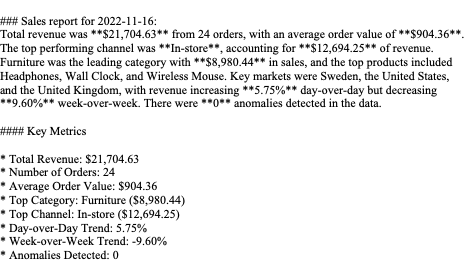
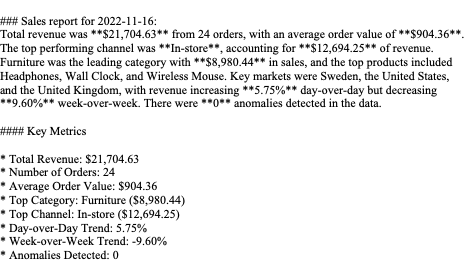
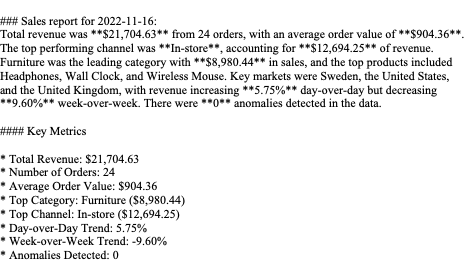
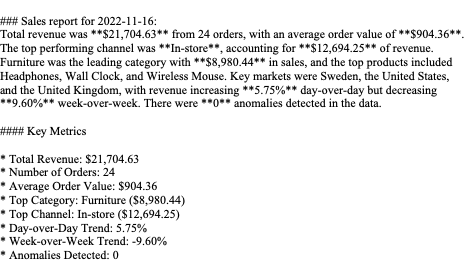

## Section 7: Agent Evaluation

 - Here the agent performance will be evaluated

## Section 8: Agent Memory (Context Engineering)

 - Here the agent will be enhanced with memory so that it can have further conversations with the user.